In [220]:
from __future__ import print_function 
%cd /Users/sophiatonelli/library_script/script
from scipy.ndimage import gaussian_filter1d
import tools21cm as t2c
import os, sys 
from scipy.interpolate import interp1d
import math
from scipy.stats import gaussian_kde
os.chdir('/Users/sophiatonelli/library_script/script/work')
sys.path.append(os.getcwd())
import script
sys.path.append(os.getcwd())
import numpy as np 
import matplotlib.pyplot as plt 
import script 
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})

/Users/sophiatonelli/library_script/script


AFTER I RUN THE ES-PC SCENARIOS FOR ZETA CONSTANT/MASS INDEPENDENT, I USE THIS CODE TO SELECT 1 SCENARIO WITH RESPECTIVE PARAMETER AND STUDY THE TRENDS OF PC AND ES AS RESOLUTION CHANGES-

In [221]:
gadget_snap = '/Users/sophiatonelli/Downloads/snap_120' 
outpath = '/Users/sophiatonelli/library_script/script/work/script_files' 
scaledist = 1e-3 
default_simulation_data = script.default_simulation_data(gadget_snap, outpath, sigma_8=0.829, ns=0.961, omega_b=0.0482, scaledist=scaledist)

print("Simulation box size:", default_simulation_data.box, "cMpc/h") 
print("Simulation redshift:", default_simulation_data.z) 

Simulation box size: 256.0 cMpc/h
Simulation redshift: 8.0


EXAMPLE xhi=0.2 pc vs es, resolutions (redshift 6)

In [222]:
#select resolution and values for reionization parameters

ngrid = 64 #i.e. resolution 256/128 cMpc/h)
matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=False) 
log10Mmin = 9.0 
fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin) 
xhi_target = 0.5

In [223]:
cell_size=256/ngrid #cMpc/h
print(cell_size, "cMpc/h")

4.0 cMpc/h


0.5000002


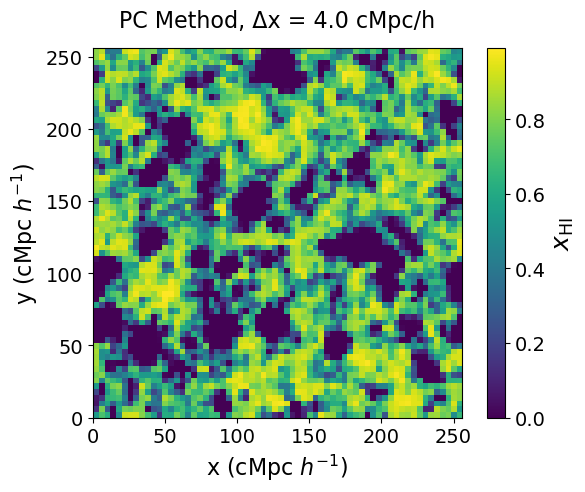

In [224]:
#ionization map for PC method

zeta_pc = 25.0782

ionization_map = script.ionization_map(matter_fields)
delta = matter_fields.densitycontr_arr
qi_arr = ionization_map.get_qi(zeta_pc * fcoll_arr) 

delta=matter_fields.densitycontr_arr
xhi=(1-qi_arr*(1+delta)).mean()
print(xhi)

im_q = plt.imshow(1-qi_arr[:,:,int(0.5*ngrid)],extent=[0,default_simulation_data.box,0,default_simulation_data.box], cmap='viridis')
cbar=plt.colorbar(im_q, label=r'$x_{\mathrm{HI}}$')
cbar.ax.yaxis.label.set_size(18)  
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'x (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r'y (cMpc $h^{-1}$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'PC Method, Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.show()

yt : [INFO     ] 2025-08-07 11:27:58,045 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-08-07 11:27:58,050 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-08-07 11:27:58,054 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-07 11:27:58,054 Parameters: domain_right_edge         = [256. 256. 256.]
yt : [INFO     ] 2025-08-07 11:27:58,056 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-08-07 11:27:58,727 Creating transfer function
yt : [INFO     ] 2025-08-07 11:27:58,728 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2025-08-07 11:27:58,844 Rendering scene (Can take a while).
yt : [INFO     ] 2025-08-07 11:27:58,859 Creating volume


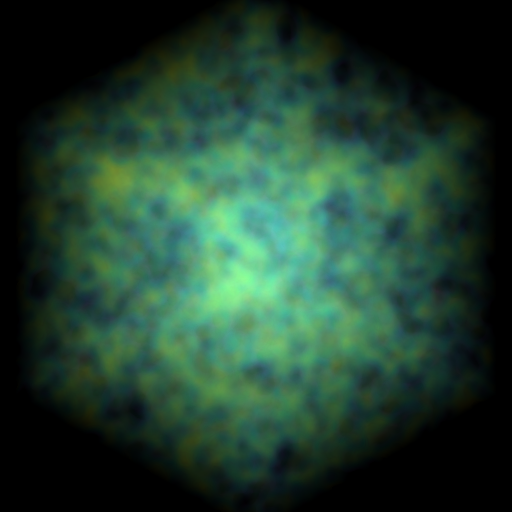

In [ ]:
import yt
xhi_arr = 1-qi_arr*(1+delta)
data = {"x_HI": xhi_arr.astype(np.float32)}
ngrid = xhi_arr.shape[0]
bbox = np.array([[0, default_simulation_data.box]] * 3)
ds = yt.load_uniform_grid(data, domain_dimensions=xhi_arr.shape, length_unit="Mpc", bbox=bbox, nprocs=1,periodicity=(True, True, True))
sc = yt.create_scene(ds, field=("stream", "x_HI"))
source = sc[0]
source.set_log(False)
tf = source.transfer_function
tf.clear()
bounds = np.linspace(0, 1, 10) #vals between 0 and 1 for opacity ramp
for b in bounds:
    tf.sample_colormap(b, 0.02, colormap="viridis", alpha=0.3)

sc.show()


0.4999998


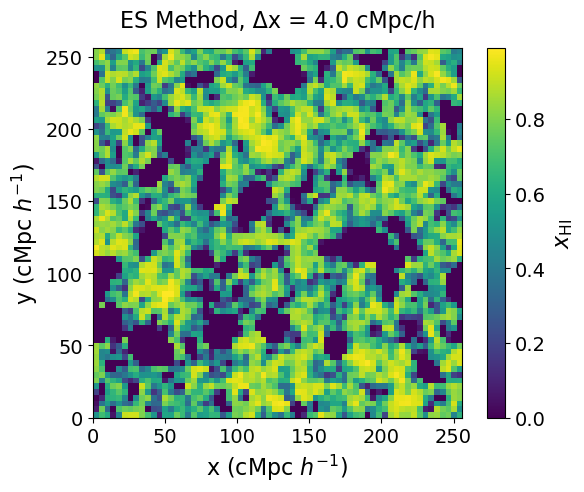

In [226]:
# ionization map for ES method

zeta_es = 26.9484  #BASED ON NGRID 64, LOG10Mmin 9.0, and xhi_target 0.50
es_ionization_map = script.ionization_map(matter_fields, method='ES')
es_qi_arr = es_ionization_map.get_qi(zeta_es * fcoll_arr)
print((1 - es_qi_arr * (1+delta)).mean())
es_im_q = plt.imshow(1 - es_qi_arr[:,:,int(0.5*ngrid)], extent=[0,default_simulation_data.box, 0, default_simulation_data.box], cmap='viridis')
es_cbar = plt.colorbar(es_im_q, label= r'$x_{\mathrm{HI}}$')
es_cbar.ax.yaxis.label.set_size(16)  
es_cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'x (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r'y (cMpc $h^{-1}$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'ES Method, Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.show()

In [227]:
box_size = default_simulation_data.box  #in cMpc/h
cell_size = box_size / ngrid
print("cell size:",cell_size, "cMpc/h")

cell size: 4.0 cMpc/h


In [228]:
# helper functions


def apply_periodic_index(idx, ngrid):
    return idx % ngrid

def apply_periodic_pos(pos, ngrid):
    return np.mod(pos, ngrid)

def choose_random_direction(): 
    theta = np.arccos(np.random.uniform(-1, 1))  #theta range: 0 to pi
    phi = np.random.uniform(0, 2 * np.pi)
    x_vec = np.sin(theta) * np.cos(phi)
    y_vec = np.sin(theta) * np.sin(phi)
    z_vec = np.cos(theta)
    return np.array([x_vec, y_vec, z_vec], dtype=np.float64)

def launching_rays(start_idx, random_direction_vector, ionized_mask, ngrid, cell_size, step_size=1.0): 
    pos = np.array(start_idx, dtype=np.float64)
    distance=0.0
    max_distance = 3 * ngrid 
    while distance < max_distance:
        pos += random_direction_vector * step_size
        pos = apply_periodic_pos(pos, ngrid) 
        idx = np.floor(pos).astype(int) 
        idx = apply_periodic_index(idx, ngrid)
        if not ionized_mask[tuple(idx)]:
            return distance * cell_size 
        distance += step_size      
    return max_distance * cell_size  

In [229]:
# monte carlo sampling: MFP algorithm to determine the bubble size distribution

threshold = 0.5 #1.0
num_iterations = 100000 #

PC_mean_free_paths = []
ES_mean_free_paths = []

pc_ionized_mask = (qi_arr >= threshold)
es_ionized_mask = (es_qi_arr >= threshold)

for method, ionized_mask in zip(['PC', 'ES'], [pc_ionized_mask, es_ionized_mask]):
    for _ in range(num_iterations):
        idx = np.random.randint(0, ngrid, size=3)
        if not ionized_mask[tuple(idx)]:
            continue
        vector_direction = choose_random_direction()
        mfp = launching_rays(idx, vector_direction, ionized_mask, ngrid, cell_size)
        if method == 'PC':
            PC_mean_free_paths.append(mfp)
        else:
            ES_mean_free_paths.append(mfp)

PC_physical_mfp = np.array(PC_mean_free_paths)
ES_physical_mfp = np.array(ES_mean_free_paths)

print(PC_mean_free_paths)
print(ES_mean_free_paths)
    

[8.0, 8.0, 4.0, 4.0, 4.0, 8.0, 0.0, 8.0, 4.0, 4.0, 32.0, 4.0, 12.0, 8.0, 4.0, 4.0, 0.0, 8.0, 20.0, 12.0, 4.0, 40.0, 12.0, 24.0, 8.0, 12.0, 0.0, 4.0, 12.0, 24.0, 12.0, 0.0, 8.0, 16.0, 4.0, 16.0, 16.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 8.0, 32.0, 4.0, 0.0, 0.0, 4.0, 0.0, 40.0, 0.0, 4.0, 4.0, 0.0, 12.0, 0.0, 4.0, 0.0, 20.0, 4.0, 4.0, 24.0, 0.0, 16.0, 8.0, 0.0, 8.0, 12.0, 4.0, 0.0, 8.0, 0.0, 4.0, 20.0, 4.0, 8.0, 8.0, 12.0, 0.0, 12.0, 0.0, 0.0, 16.0, 8.0, 0.0, 0.0, 16.0, 0.0, 0.0, 12.0, 8.0, 16.0, 8.0, 0.0, 28.0, 4.0, 4.0, 4.0, 12.0, 12.0, 0.0, 8.0, 4.0, 8.0, 8.0, 0.0, 0.0, 8.0, 0.0, 16.0, 0.0, 12.0, 4.0, 0.0, 0.0, 28.0, 0.0, 40.0, 4.0, 0.0, 0.0, 4.0, 8.0, 0.0, 8.0, 12.0, 0.0, 4.0, 0.0, 12.0, 24.0, 0.0, 40.0, 4.0, 4.0, 0.0, 0.0, 0.0, 8.0, 4.0, 16.0, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 0.0, 16.0, 12.0, 8.0, 4.0, 0.0, 4.0, 0.0, 0.0, 8.0, 4.0, 16.0, 16.0, 0.0, 52.0, 12.0, 4.0, 4.0, 24.0, 0.0, 20.0, 4.0, 0.0, 48.0, 4.0, 16.0, 4.0, 40.0, 20.0, 4.0, 0.0, 4.0, 32.0, 8.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 0.0, 

In [230]:
# normalized and interpolated BSDs: 1. PC method, 2. ES method, 3. Tools21cm with PC for comaprison
# determine the peak of the PC BSD


R_min = cell_size 
R_max = box_size
smooth_R = np.linspace(R_min, R_max, 64 ) #128,64 #only 64 bins in this case for pre-fixed resolution
R_dense = np.linspace(smooth_R[0], smooth_R[-1], 1000)

# PC
PC_kde = gaussian_kde(PC_physical_mfp)
PC_smooth_pdf = PC_kde(smooth_R)
PC_bsd = smooth_R * PC_smooth_pdf
PC_bsd /= np.trapz(PC_bsd, smooth_R)
print("PC bsd", np.trapz(PC_bsd, smooth_R))
curve_PC_bsd = interp1d(smooth_R, PC_bsd, kind='cubic', fill_value="extrapolate")
dense_PC_bsd = curve_PC_bsd(R_dense)

# peak
peak_idx = np.argmax(dense_PC_bsd) 
R_peak = R_dense[peak_idx]
peak = dense_PC_bsd[peak_idx]
print("peak", R_peak)
#np.save('R_peak.npy', R_peak)

# ES
ES_kde = gaussian_kde(ES_physical_mfp)
ES_smooth_pdf = ES_kde(smooth_R)
ES_bsd = smooth_R * ES_smooth_pdf
ES_bsd /= np.trapz(ES_bsd, smooth_R)
curve_ES_bsd = interp1d(smooth_R, ES_bsd, kind='cubic', fill_value="extrapolate")
dense_ES_bsd = curve_ES_bsd(R_dense)

# Tools21cm Model
PC_r_mfp, PC_dn_mfp = t2c.mfp(pc_ionized_mask, boxsize=box_size, iterations=10000000)
mask_PC = PC_r_mfp >= R_min
PC_r_mfp = PC_r_mfp[mask_PC]
r_mfp_dense = np.linspace(PC_r_mfp[0], PC_r_mfp[-1], 1000)
PC_dn_mfp = PC_dn_mfp[mask_PC]
PC_dn_mfp /= np.trapz(PC_dn_mfp, PC_r_mfp)  
print("area pdf tools21", np.trapz(PC_dn_mfp, PC_r_mfp))
curve_PC_dn = interp1d(PC_r_mfp, PC_dn_mfp, kind='cubic', fill_value="extrapolate")
dense_PC_dn = curve_PC_dn(r_mfp_dense)

PC bsd 0.9999999999999999
peak 8.792792792792792
94945/262144 cells are marked as region of interest (ROI).
MFP method applied on 3D data.
Initialising random rays... done
Estimating ray lengths...


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]



Program runtime: 0.63 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
area pdf tools21 1.0


In [231]:
from scipy.optimize import fsolve
def safe_fsolve(func, guess, description=""):
    sol, info, ier, msg = fsolve(func, guess, full_output=True)
    if ier != 1:
        print(f"[fsolve failed] {description} → msg: {msg}")
        return np.nan
    return sol[0]

[92]
length idx is 1
1 point  23.207207207207205
[ 1 55]
length second idx is 2
2 points  13.621621621621621


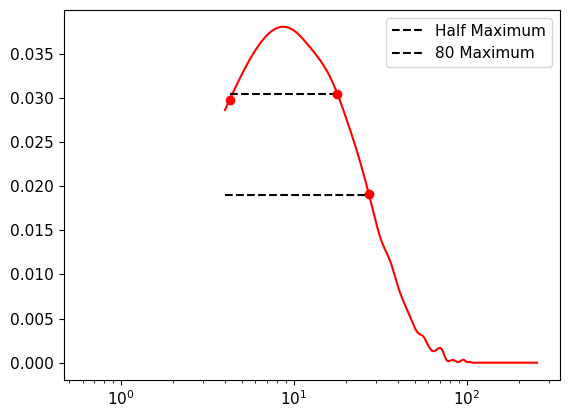

23.207207207207205 , width
13.621621621621621 , 80 width


In [ ]:
# estimate intersection points for FWHM + 80% FWM       


y_target = dense_PC_bsd[peak_idx] / 2.0   
y_80target = dense_PC_bsd[peak_idx] * 0.80 
idx = np.argwhere(np.diff(np.sign(y_target - dense_PC_bsd))).flatten()
print(idx)
print("length idx is",len(idx))
if len(idx)>2:
    width = np.nan
    print(width)
elif len(idx)==2:
    width= R_dense[idx[1]] - R_dense[idx[0]]
    print("2 points ",width)
elif len(idx)==1 and R_dense[idx[0]]>R_peak:
    width = R_dense[idx[0]] - cell_size
    print("1 point ",width)
else:
    width=np.nan

second_idx = np.argwhere(np.diff(np.sign(y_80target - dense_PC_bsd))).flatten()
print(second_idx)
print("length second idx is",len(second_idx))
if len(second_idx)>2:
    second_width = np.nan
    print(second_width)
elif len(second_idx)==2:
    second_width = R_dense[second_idx[1]] - R_dense[second_idx[0]]
    print("2 points ",second_width)
elif len(second_idx)==1 and R_dense[second_idx[0]]>R_peak:
    second_width = R_dense[second_idx[0]] - cell_size
    print("1 point ",second_width)
else:
    width=np.nan

plt.hlines(y=y_target, xmin=cell_size, xmax=R_dense[idx[0]], color='black', linestyle='--', label='Half Maximum')
plt.plot(R_dense, dense_PC_bsd, c="r") #plt.axhline(y_target, c='g') #plt.axhline(y_80target, c='g')
plt.xscale("log")
plt.plot(R_dense[idx], dense_PC_bsd[idx], 'ro')
plt.hlines(y=y_80target, xmin=R_dense[second_idx][0], xmax=R_dense[second_idx][1], color='black', linestyle='--', label='80 Maximum')
plt.plot(R_dense[second_idx], dense_PC_bsd[second_idx], 'ro')
plt.legend(frameon=False)
plt.show()

print(width, ", width")
print(second_width, ", 80 width")




23.207207207207205 segment length for half max
13.621621621621621 80% fwm


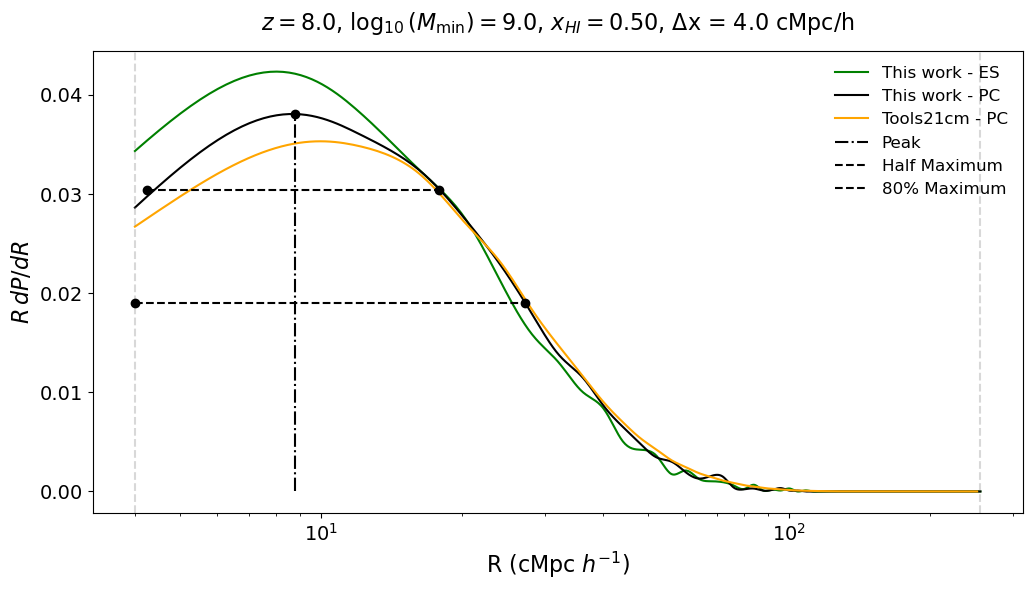

In [236]:
# final sumamry plot 

print(width, "segment length for half max")
print(second_width, r"80% fwm")

plt.figure(figsize=(12,6))

# my algorithm PC + ES BSDs
plt.plot(R_dense, dense_ES_bsd, label = 'This work - ES', color = 'green' ) 
plt.plot(R_dense, dense_PC_bsd, label='This work - PC', color='black') 

# Tools21cm model BSD
plt.plot(r_mfp_dense, dense_PC_dn,label='Tools21cm - PC', color='orange') 

# resolution limit + peak line + FWHM line
plt.axvline(cell_size, linestyle = '--', color='grey', alpha=0.3)
plt.axvline(256, linestyle = '--', color='grey', alpha=0.3)
plt.vlines(R_peak, ymin=0, ymax=peak, linestyles='-.', color = 'black', label = 'Peak')
plt.hlines(y=y_target, xmin=cell_size, xmax=R_dense[idx[0]], color='black', linestyle='--', label='Half Maximum') #cell_size
plt.hlines(y=y_80target, xmin=R_dense[second_idx[0]], xmax=R_dense[second_idx[1]], color='black', linestyle='--', label='80% Maximum') #cell_size
#plt.hlines(y = peak, xmin= cell_size , xmax= R_peak, color='black', linestyle='--', label='Peak Height')
plt.scatter([ R_dense[second_idx[0]], R_dense[second_idx[1]] ], [y_80target, y_80target], color='black', zorder=5) #cell_size
plt.scatter([cell_size, R_dense[idx[0]]], [y_target, y_target], color='black', zorder=5) #cell_size
plt.scatter(R_peak, peak, color='black', zorder=5)


plt.legend(fontsize=12, loc='upper right', frameon=False)
plt.title( rf'$z = {default_simulation_data.z}$, 'rf'$\log_{{10}}(M_{{\min}}) = {log10Mmin}$, 'rf'$x_{{HI}}= {xhi_target:.2f}$, 'rf'Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.xscale('log')
plt.xlabel(r'R (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r"$R\,dP/dR$", fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

746385/2097152 cells are marked as region of interest (ROI).
MFP method applied on 3D data.
Initialising random rays... done
Estimating ray lengths...


100%|██████████| 128/128 [01:06<00:00,  1.94it/s]



Program runtime: 1.22 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
area pdf tools21 0.9999999999999998
94945/262144 cells are marked as region of interest (ROI).
MFP method applied on 3D data.
Initialising random rays... done
Estimating ray lengths...


100%|██████████| 64/64 [00:47<00:00,  1.34it/s]



Program runtime: 0.93 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
area pdf tools21 0.9999999999999999
12515/32768 cells are marked as region of interest (ROI).
MFP method applied on 3D data.
Initialising random rays... done
Estimating ray lengths...


100%|██████████| 32/32 [00:33<00:00,  1.06s/it]



Program runtime: 0.61 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
area pdf tools21 1.0


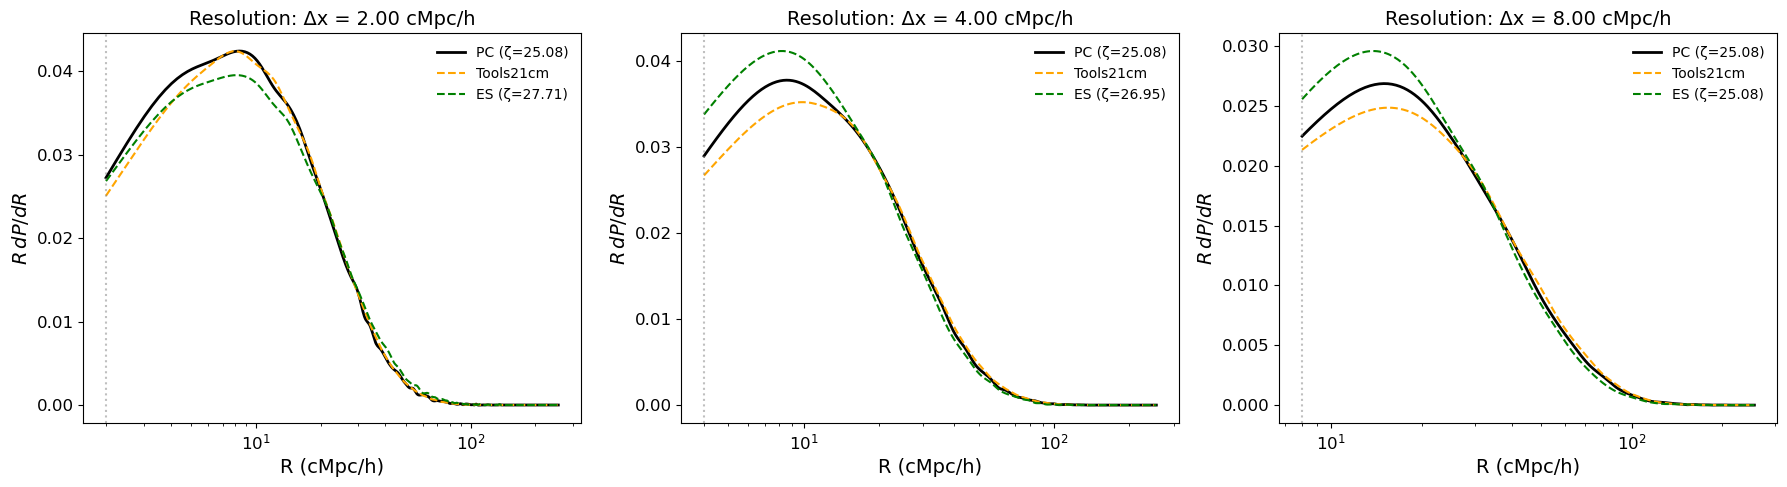

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
ngrids_list = [128, 64, 32]
zeta_pc = 25.07820545231314
list_zeta_es = [27.71, 26.95, 25.08]
threshold = 0.5
num_iterations = 1000000
log10Mmin = 9.0


for idx, (ngrid, zeta_es) in enumerate(zip(ngrids_list, list_zeta_es)):
    box_size = default_simulation_data.box
    cell_size = box_size / ngrid
    R_min = cell_size
    R_max = box_size
    smooth_R = np.linspace(R_min, R_max, ngrid)
    R_dense = np.linspace(smooth_R[0], smooth_R[-1], 1000)

    matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=True)
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)

    # PC method 
    ionization_map_pc = script.ionization_map(matter_fields)
    qi_arr_pc = ionization_map_pc.get_qi(zeta_pc * fcoll_arr)
    ionized_mask_pc = (qi_arr_pc >= threshold)
    mean_free_paths_pc = []
    for _ in range(num_iterations):
        idx_rand = np.random.randint(0, ngrid, size=3)
        if not ionized_mask_pc[tuple(idx_rand)]:
            continue
        vector_direction = choose_random_direction()
        mfp = launching_rays(idx_rand, vector_direction, ionized_mask_pc, ngrid, cell_size)
        mean_free_paths_pc.append(mfp)
    physical_mfp_pc = np.array(mean_free_paths_pc)
    kde_pc = gaussian_kde(physical_mfp_pc)
    smooth_pdf_pc = kde_pc(smooth_R)
    bsd_pc = smooth_R * smooth_pdf_pc
    bsd_pc /= np.trapz(bsd_pc, smooth_R)
    dense_bsd_pc = interp1d(smooth_R, bsd_pc, kind='cubic', fill_value="extrapolate")(R_dense)

    axs[idx].plot(R_dense, dense_bsd_pc, label=f'PC (ζ={zeta_pc:.2f})', color='black', linewidth=2)

    # ES method 
    ionization_map_es = script.ionization_map(matter_fields, method='ES')
    qi_arr_es = ionization_map_es.get_qi(zeta_es * fcoll_arr)
    ionized_mask_es = (qi_arr_es >= threshold)
    mean_free_paths_es = []
    for _ in range(num_iterations):
        idx_rand = np.random.randint(0, ngrid, size=3)
        if not ionized_mask_es[tuple(idx_rand)]:
            continue
        vector_direction_es = choose_random_direction()
        mfp_es = launching_rays(idx_rand, vector_direction_es, ionized_mask_es, ngrid, cell_size)
        mean_free_paths_es.append(mfp_es)
    physical_mfp_es = np.array(mean_free_paths_es)
    kde_es = gaussian_kde(physical_mfp_es)
    smooth_pdf_es = kde_es(smooth_R)
    bsd_es = smooth_R * smooth_pdf_es
    bsd_es /= np.trapz(bsd_es, smooth_R)
    dense_bsd_es = interp1d(smooth_R, bsd_es, kind='cubic', fill_value="extrapolate")(R_dense)

    PC_r_mfp, PC_dn_mfp = t2c.mfp(ionized_mask_pc, boxsize=box_size, iterations=10000000)
    mask_PC = PC_r_mfp >= R_min
    PC_r_mfp = PC_r_mfp[mask_PC]
    r_mfp_dense = np.linspace(PC_r_mfp[0], PC_r_mfp[-1], 1000)
    PC_dn_mfp = PC_dn_mfp[mask_PC]
    PC_dn_mfp /= np.trapz(PC_dn_mfp, PC_r_mfp)  
    print("area pdf tools21", np.trapz(PC_dn_mfp, PC_r_mfp))
    curve_PC_dn = interp1d(PC_r_mfp, PC_dn_mfp, kind='cubic', fill_value="extrapolate")
    dense_PC_dn = curve_PC_dn(r_mfp_dense)
    axs[idx].plot(r_mfp_dense, dense_PC_dn, label=f'Tools21cm', color='orange', linestyle='--')

    axs[idx].plot(R_dense, dense_bsd_es, label=f'ES (ζ={zeta_es:.2f})', color='green', linestyle='--')

    
    axs[idx].axvline(cell_size, linestyle=':', color='grey', alpha=0.5)
    axs[idx].set_xscale('log')
    axs[idx].set_xlabel("R (cMpc/h)", fontsize=14)
    axs[idx].set_ylabel(r"$R\,dP/dR$", fontsize=14)
    axs[idx].tick_params(labelsize=12)
    axs[idx].legend(fontsize=10, loc='upper right', frameon=False)
    axs[idx].set_title(f'Resolution: Δx = {cell_size:.2f} cMpc/h', fontsize=14)

plt.tight_layout()
plt.show()
